## load data

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [33]:
# Directory where the .npy files are stored
DATA_FOLDER = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\data\processed"
class IsovistDataset(Dataset):
    def __init__(self, data_folder):
        self.data = []
        self.file_names = []

        for f in os.listdir(data_folder):
            if f.endswith('.npy'):
                path = os.path.join(data_folder, f)
                array = np.load(path)  # Load ONCE
                self.data.append(torch.tensor(array, dtype=torch.float32))
                self.file_names.append(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.file_names[idx]

# Create Dataset and DataLoader
dataset = IsovistDataset(DATA_FOLDER)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


## frame encoding

In [34]:
# Define the MLP to encode each isovist (2048 → 128)
class IsovistFrameEncoder(nn.Module):
    def __init__(self):
        super(IsovistFrameEncoder, self).__init__()
        
        # Define a simple MLP architecture
        self.fc1 = nn.Linear(2048, 512)  # First layer (2048 → 512)
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(512, 128)  # Second layer (512 → 128)
        
    def forward(self, x):
        """
        Forward pass for frame encoding
        x: tensor of shape [batch_size, 2048]
        """
        x = self.relu(self.fc1(x))  # First layer
        x = self.fc2(x)  # Second layer
        return x


In [35]:
class TemporalTransformerEncoder(nn.Module):
    def __init__(self, input_dim=128, num_heads=4, ff_dim=256, num_layers=3):
        """
        A Transformer Encoder that processes the 7-frame sequence.
        """
        super(TemporalTransformerEncoder, self).__init__()
        
        # Define transformer encoder layer with batch_first=True
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,  # Each frame has 128 features
            nhead=num_heads,  # Number of attention heads
            dim_feedforward=ff_dim,  # Feed-forward layer size
            batch_first=True  # Ensure batch-first format (batch_size, seq_len, input_dim)
        )
        
        # Wrap encoder layers in a TransformerEncoder
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, 
            num_layers=num_layers  # Number of transformer layers
        )

    def forward(self, x):
        """
        Forward pass for the temporal transformer
        x: tensor of shape [batch_size, seq_len, input_dim]
        """
        return self.transformer_encoder(x)

In [36]:
class SpatioTemporalModel(nn.Module):
    def __init__(self):
        super(SpatioTemporalModel, self).__init__()
        self.frame_encoder = IsovistFrameEncoder()  # Frame encoding layer
        self.temporal_encoder = TemporalTransformerEncoder(input_dim=128)  # Transformer encoder

    def forward(self, x):
        # x: [batch_size, seq_len, 2048]
        
        # Step 1: Encode each frame (2048 → 128)
        batch_size, seq_len, _ = x.shape
        x_reshaped = x.view(-1, 2048)                # [B×7, 2048]
        encoded = self.frame_encoder(x_reshaped)     # [B×7, 128]
        frame_embeddings = encoded.view(batch_size, seq_len, 128)  # [B, 7, 128]
        
        # Step 2: Apply Transformer to sequence of frame embeddings (7, 128) → (7, 128)
        transformer_output = self.temporal_encoder(frame_embeddings)  # shape: [batch_size, 7, 128]
        
        # Step 3: Aggregate over the sequence (mean pooling)
        aggregated = transformer_output.mean(dim=1)  # shape: [batch_size, 128]
        
        return aggregated


In [37]:
class NT_XentLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(NT_XentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        """
        Compute the normalized temperature-scaled cross-entropy loss.
        """
        batch_size = z1.size(0)
        
        # Compute similarity
        similarity_matrix = torch.matmul(z1, z2.T) / self.temperature
        
        # Create labels: 0,1 for positive pair (same batch)
        labels = torch.arange(batch_size).to(z1.device)
        
        # Cross entropy loss
        loss = nn.CrossEntropyLoss()(similarity_matrix, labels)
        return loss


## model training

In [39]:
# Define the directories for saving models
CHECKPOINT_FOLDER = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\data\checkpoints"

# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
TEMPERATURE = 0.1  # for SimCLR

# Function for visualizing loss over training epochs
def plot_loss(training_losses):
    plt.plot(training_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# SimCLR loss function (NT-Xent Loss)
class NT_XentLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(NT_XentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        """
        Compute the normalized temperature-scaled cross-entropy loss (NT-Xent Loss).
        """
        batch_size = z1.size(0)
        
        # Compute cosine similarity between all pairs
        similarity_matrix = torch.matmul(z1, z2.T) / self.temperature  # similarity = cos(theta)
        
        # Create labels: 0,1 for positive pair (same batch)
        labels = torch.arange(batch_size).to(z1.device)
        
        # Cross entropy loss
        loss = nn.CrossEntropyLoss()(similarity_matrix, labels)
        return loss

# Initialize your model
model = SpatioTemporalModel()  # Assuming you already have SpatioTemporalModel defined earlier
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = NT_XentLoss(temperature=TEMPERATURE)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
def train_one_epoch(model, data_loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    total_batches = len(data_loader)
    
    for batch_data, _ in data_loader:
        batch_data = batch_data.to(device)
        
        # Step 1: Forward pass through the model
        z1 = model(batch_data)  # Get the latent vector for first view (e.g., augmented version 1)
        
        # Apply augmentation (e.g., jitter, scaling) to generate a second view for contrastive learning
        augmented_data = batch_data + 0.01 * torch.randn_like(batch_data)
        z2 = model(augmented_data)  # Get the latent vector for second view (augmented version 2)


        # Step 2: Compute the contrastive loss (SimCLR)
        loss = loss_fn(z1, z2)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the loss
        running_loss += loss.item()

    epoch_loss = running_loss / total_batches
    return epoch_loss

# Lists to track loss for visualization
training_losses = []

# Training loop
best_loss = float('inf')

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Training phase
    train_loss = train_one_epoch(model, data_loader, optimizer, loss_fn, device)
    print(f"Training Loss: {train_loss:.4f}")
    
    # Optional validation phase
    # val_loss = validate(model, val_loader, device)  # If you have a validation set
    # print(f"Validation Loss: {val_loss:.4f}")

    # Save the model checkpoint if it improves
    if train_loss < best_loss:
        best_loss = train_loss
        checkpoint_path = os.path.join(CHECKPOINT_FOLDER, f"model_epoch_{epoch + 1}.pt")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved model checkpoint at epoch {epoch + 1}")
    
    # Track loss for visualization
    training_losses.append(train_loss)

# Plot the loss curve
# plot_loss(training_losses)

print(training_losses)

print("Training complete!")


Epoch 1/10
Training Loss: 1.9659
Saved model checkpoint at epoch 1
Epoch 2/10
Training Loss: 1.3840
Saved model checkpoint at epoch 2
Epoch 3/10
Training Loss: 0.9287
Saved model checkpoint at epoch 3
Epoch 4/10
Training Loss: 0.7746
Saved model checkpoint at epoch 4
Epoch 5/10
Training Loss: 0.5751
Saved model checkpoint at epoch 5
Epoch 6/10
Training Loss: 0.3996
Saved model checkpoint at epoch 6
Epoch 7/10
Training Loss: 0.5619
Epoch 8/10
Training Loss: 0.4288
Epoch 9/10
Training Loss: 0.3153
Saved model checkpoint at epoch 9
Epoch 10/10
Training Loss: 0.2214
Saved model checkpoint at epoch 10
[1.965945724930082, 1.3839532903262548, 0.9287085235118866, 0.7746294832655362, 0.5750683290617806, 0.3995683698781899, 0.5619344440341852, 0.42880132774423274, 0.3153224682090305, 0.2213611602783203]
Training complete!


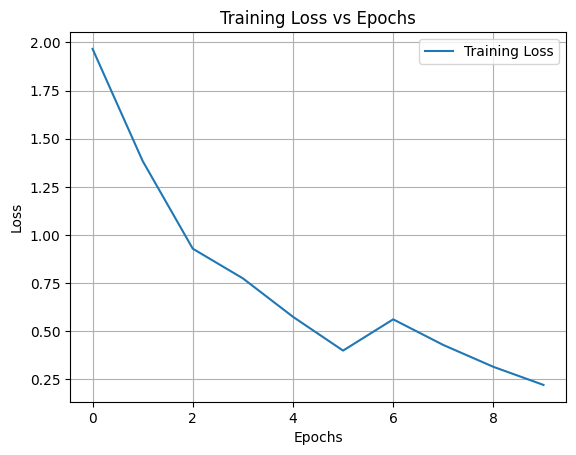

In [40]:
plot_loss(training_losses)

In [41]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Extract latent vectors from the dataset
def extract_latent_vectors(model, data_loader, device):
    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for batch_data, file_names in data_loader:
            batch_data = batch_data.to(device)
            
            # Get latent vector for each sample
            latent_vector = model(batch_data)  # shape: [batch_size, 128]
            latent_vectors.append(latent_vector.cpu().numpy())
            
            # Optional: store file names for labeling clusters
            labels.extend(file_names)
    
    return np.concatenate(latent_vectors, axis=0), labels

# Extract latent vectors (this will be done after model training)
latent_vectors, labels = extract_latent_vectors(model, data_loader, device)
print("Latent vectors shape:", latent_vectors.shape)


Latent vectors shape: (200, 128)


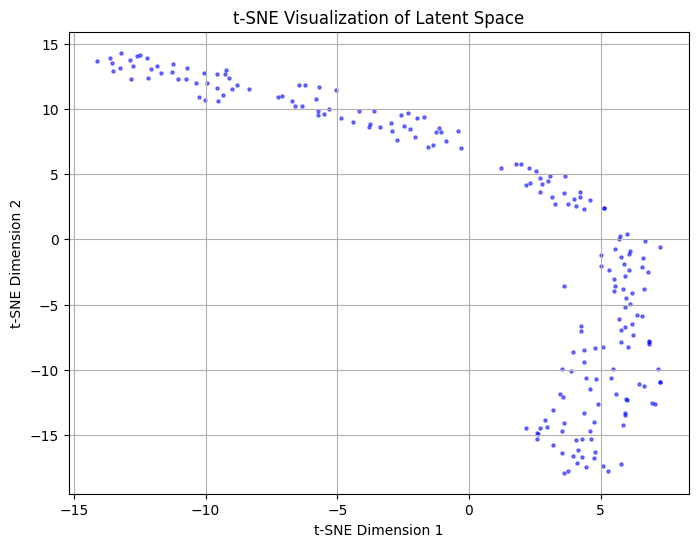

In [42]:
# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
latent_vectors_2d = tsne.fit_transform(latent_vectors)

# Plot the t-SNE projection
plt.figure(figsize=(8, 6))
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c='blue', s=5, alpha=0.5)
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()


C:\Users\shrua\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


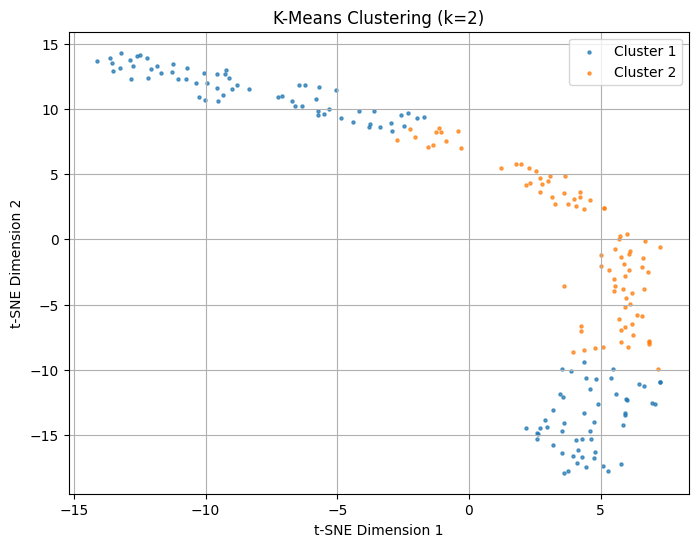

In [43]:
# Apply KMeans clustering to the latent vectors
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels_kmeans = kmeans.fit_predict(latent_vectors)

# Plot the t-SNE projection with K-means cluster coloring
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(latent_vectors_2d[labels_kmeans == i, 0], latent_vectors_2d[labels_kmeans == i, 1], label=f'Cluster {i + 1}', s=5, alpha=0.7)

plt.title(f"K-Means Clustering (k={num_clusters})")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


In [44]:
import re

# Function to extract group from filename
def extract_group_from_filename(filename):
    match = re.match(r"t(\d+)-", filename)
    if match:
        return int(match.group(1))  # Returns the group number (1 to 8)
    return None  # Return None if no match found

# Extract true labels (group numbers) from file names in dataset
true_labels = [extract_group_from_filename(f) for f in dataset.file_names]


Latent vectors shape: (200, 128)


C:\Users\shrua\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


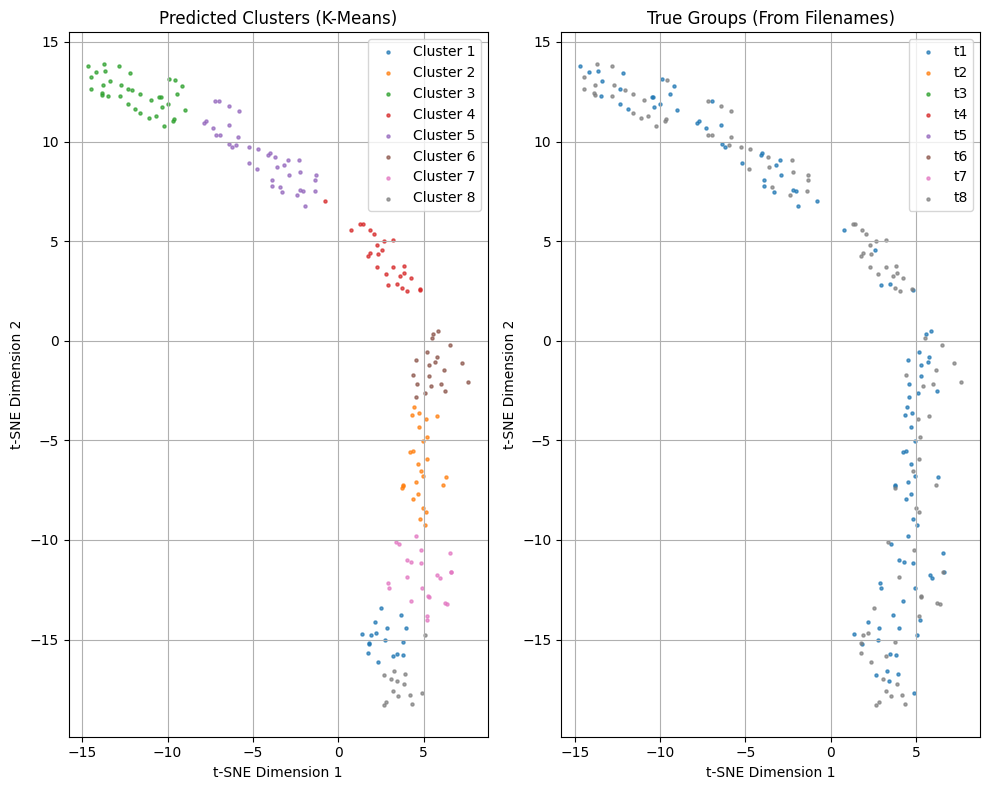

In [45]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Extract latent vectors from the dataset
def extract_latent_vectors(model, data_loader, device):
    model.eval()
    latent_vectors = []
    
    with torch.no_grad():
        for batch_data, _ in data_loader:
            batch_data = batch_data.to(device)
            
            # Get latent vector for each sample
            latent_vector = model(batch_data)  # shape: [batch_size, 128]
            latent_vectors.append(latent_vector.cpu().numpy())
    
    return np.concatenate(latent_vectors, axis=0)

# Extract latent vectors (after model training)
latent_vectors = extract_latent_vectors(model, data_loader, device)
print("Latent vectors shape:", latent_vectors.shape)

# Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, random_state=42)
latent_vectors_2d = tsne.fit_transform(latent_vectors)

# Apply KMeans clustering
num_clusters = 8  # Based on the group labels
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(latent_vectors)

# Plot t-SNE with KMeans clusters (predicted) and true labels
plt.figure(figsize=(10, 8))

# Plot predicted KMeans clusters
plt.subplot(1, 2, 1)
for i in range(num_clusters):  # 8 clusters based on "t1" to "t8"
    plt.scatter(latent_vectors_2d[predicted_labels == i, 0], latent_vectors_2d[predicted_labels == i, 1], label=f'Cluster {i+1}', s=5, alpha=0.7)
plt.title("Predicted Clusters (K-Means)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)

# Plot true labels (from filenames)
plt.subplot(1, 2, 2)
for i in range(1, 9):  # 8 true groups (t1 to t8)
    plt.scatter(latent_vectors_2d[np.array(true_labels) == i, 0], latent_vectors_2d[np.array(true_labels) == i, 1], label=f't{i}', s=5, alpha=0.7)
plt.title("True Groups (From Filenames)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
